## Exercise 4: One versus all MNIST
Part 1: Hyperparameter Tuning

**Technique for hyperparameter search**  
The GridSearchCV is used to find the optimal and best values for the hyperparameters "C" and "gamma". The grid search used a validation named "3 fold cross" and evaluated 9 different combinations of C and gamma values.   
The parameters and their values are:  
C: (0.1, 1, 10)  
gamma: (0.001, 0.01, 0.1)  

The best parameters found by GridSearchCV is:  
C = 10  
gamma = 0.01  

These parameters were used to train the final SVM model. The final model achieved a test accuracy of 96.09% which is a good test accuracy value.


**Confusion matrix**  
The confusion matrix shows the performance of the classifier in each class. Each row represents the actual class and each column represents the predicted class.   
My observations in the confusion matrix:  
There were high values along the diagonal which means that the model is predicting most of the samples accurately. For example, for class 0, 3061 out of 3107 samples are correctly classified which shows a very high and good accuracy.  
But there was some misclassification. For example the class 4 is confused with the class 9 (76 instances).  

The confusion matrix shows that the SVM model performs well but there are some pairs of classes where misclassifications are relatively higher.  


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters found: {'C': 10, 'gamma': 0.01}
Test Accuracy with RBF Kernel: 0.9609


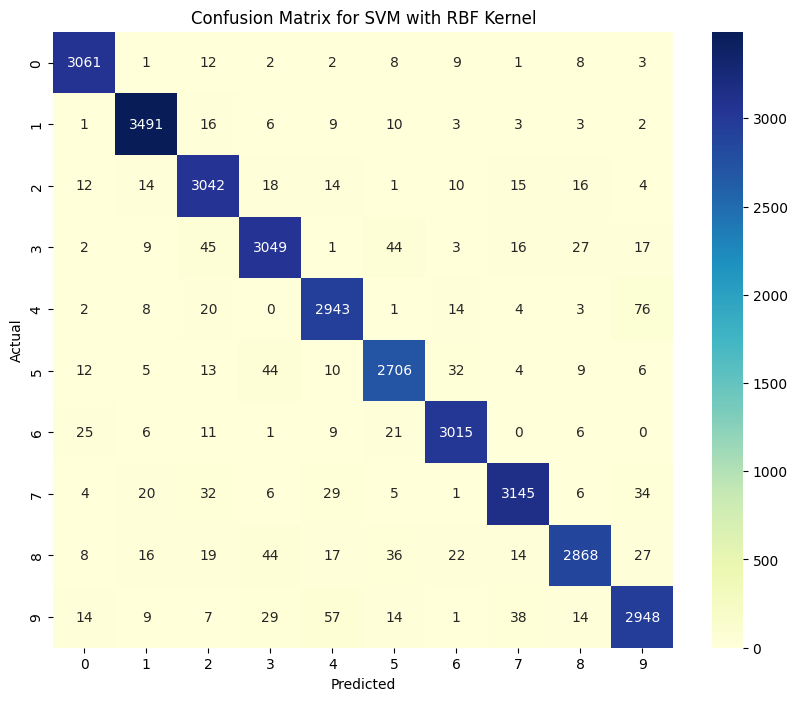

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3107
           1       0.98      0.99      0.98      3544
           2       0.95      0.97      0.96      3146
           3       0.95      0.95      0.95      3213
           4       0.95      0.96      0.96      3071
           5       0.95      0.95      0.95      2841
           6       0.97      0.97      0.97      3094
           7       0.97      0.96      0.96      3282
           8       0.97      0.93      0.95      3071
           9       0.95      0.94      0.94      3131

    accuracy                           0.96     31500
   macro avg       0.96      0.96      0.96     31500
weighted avg       0.96      0.96      0.96     31500



In [1]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import fetch_openml
import seaborn as sns

# Load the MNIST dataset from library
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data / 255.0, mnist.target.astype(int)

# training and validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.1, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Define the parameters
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1]
}

# Grid search for RBF kernel
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=3, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(f"Best parameters found: {best_params}")

# Train the final model with the best parameters
best_svc = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
best_svc.fit(X_train, y_train)
y_pred = best_svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy with RBF Kernel: {accuracy:.4f}")

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix for SVM with RBF Kernel")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))


Part 2: One-vs-One vs One-vs-All

One-vs-One Test Accuracy: 96.08%  
Custom One-vs-All Test Accuracy: 96.38%  
Both classifiers performed very well. But the One-vs-All classifier was just slightly better than the One-vs-One classifier.  

My observations for both confusion matrix:  
Both classifiers have high values along the diagonal which means a high accuracy of classifications. This confirms that both models are highly accurate like the test accuracy results I got.  
But some misclassifications are:  
For One-vs-One Classifier: Class 4 confused with class 9 (80 instances).  
For Custom One-vs-All Classifier: Class 4 confused with class 9 (72 instances).  
The One-vs-One classifier has a little bit higher misclassifications between certain class pairs when compared to the One-vs-All classifier.
For example, class 3 and class 5 confusion (49 instances) in One-vs-One compared to the 39 instances in One-vs-All.  

One-vs-One Test Accuracy: 0.9608
Custom One-vs-All Test Accuracy: 0.9638


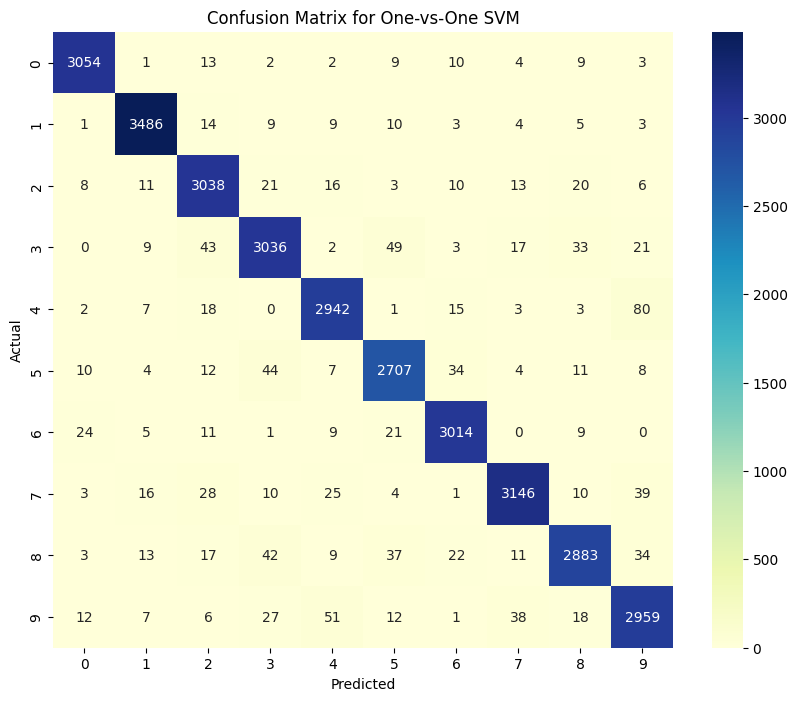

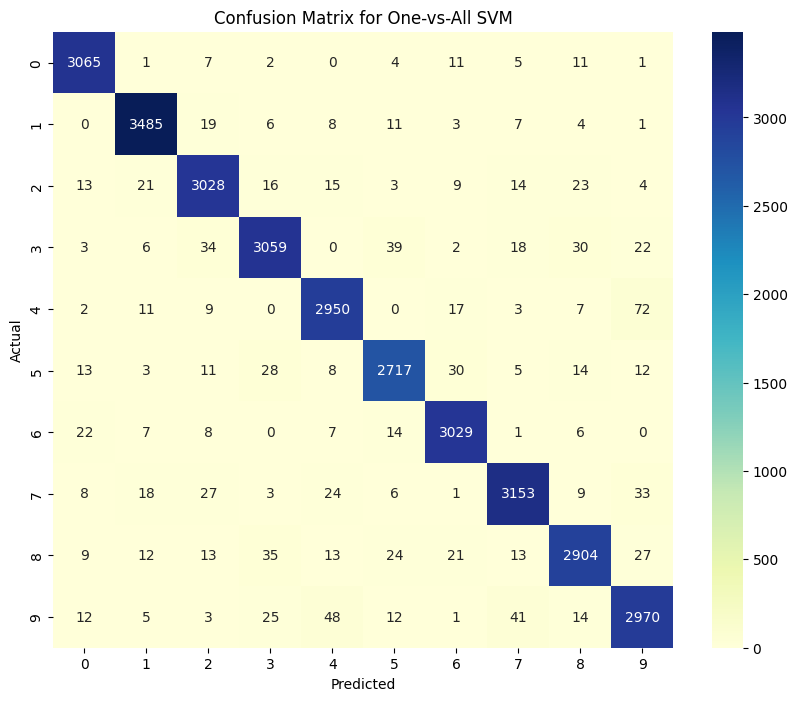

Classification Report for One-vs-One:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3107
           1       0.98      0.98      0.98      3544
           2       0.95      0.97      0.96      3146
           3       0.95      0.94      0.95      3213
           4       0.96      0.96      0.96      3071
           5       0.95      0.95      0.95      2841
           6       0.97      0.97      0.97      3094
           7       0.97      0.96      0.96      3282
           8       0.96      0.94      0.95      3071
           9       0.94      0.95      0.94      3131

    accuracy                           0.96     31500
   macro avg       0.96      0.96      0.96     31500
weighted avg       0.96      0.96      0.96     31500

Classification Report for Custom One-vs-All:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3107
           1       0.98      0.98      0.98      

In [4]:
from sklearn.multiclass import OneVsOneClassifier
import numpy as np

# One-vs-One
ovo_clf = OneVsOneClassifier(SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma']))
ovo_clf.fit(X_train, y_train)
ovo_pred = ovo_clf.predict(X_test)
ovo_accuracy = accuracy_score(y_test, ovo_pred)

# Custom One-vs-All implementation
class OneVsRestSVM:
    def __init__(self, base_classifier, **kwargs):
        self.base_classifier = base_classifier
        self.kwargs = kwargs
        self.classifiers = []
        
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.classifiers = []
        for class_ in self.classes_:
            binary_y = np.where(y == class_, 1, 0)
            clf = self.base_classifier(**self.kwargs)
            clf.fit(X, binary_y)
            self.classifiers.append(clf)
        return self
    
    def predict(self, X):
        predictions = []
        for clf in self.classifiers:
            pred = clf.decision_function(X)
            predictions.append(pred)
        predictions = np.array(predictions)
        return self.classes_[np.argmax(predictions, axis=0)]

# Custom One-vs-All
custom_ova_clf = OneVsRestSVM(SVC, kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
custom_ova_clf.fit(X_train, y_train)
ova_pred = custom_ova_clf.predict(X_test)
ova_accuracy = accuracy_score(y_test, ova_pred)

print(f"One-vs-One Test Accuracy: {ovo_accuracy:.4f}")
print(f"Custom One-vs-All Test Accuracy: {ova_accuracy:.4f}")

# Confusion matrix for One-vs-One
conf_matrix_ovo = confusion_matrix(y_test, ovo_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_ovo, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix for One-vs-One SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix for Custom One-vs-All
conf_matrix_ova = confusion_matrix(y_test, ova_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_ova, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix for One-vs-All SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification reports
print("Classification Report for One-vs-One:")
print(classification_report(y_test, ovo_pred))

print("Classification Report for Custom One-vs-All:")
print(classification_report(y_test, ova_pred))
